In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import pandas as pd
import datetime
now = datetime.datetime.now

# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading and Preprocessing

In [2]:
# Load the data
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Carbon_Bending_UC.csv')
fatigue_df

# Removing rows with null values
fatigue_df = fatigue_df.dropna()

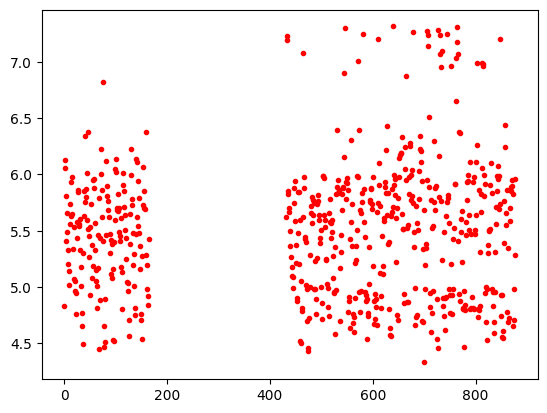

In [3]:
# Scatter Plot for the Target Column
plt.plot(np.log10(fatigue_df['Number of Cycles']), 'r.')

# Sort the data by ascending order of number of cycles
fatigue_df.sort_values(by=['Number of Cycles'], ascending=True, ignore_index=True, inplace=True)

In [4]:
# Remove columns that are not needed
drop_cols = ['Heat','Number of Cycles','Dataset'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (Mpa),Temperature (°C),Reduction Ratio,dA,dB,dC,Frequency,Elongation,Reduction of Area,C,Si,Mn,P,S,Ni,Cr,Cu
0,460,650,1270,0.04,0.01,0.00,50.0,29,70,0.42,0.26,0.70,0.024,0.010,0.01,0.01,0.01
1,500,550,825,0.11,0.04,0.00,50.0,23,67,0.42,0.22,0.78,0.022,0.020,0.01,0.02,0.03
2,470,550,825,0.08,0.00,0.00,50.0,22,68,0.33,0.21,0.75,0.031,0.019,0.01,0.03,0.02
3,580,550,825,0.10,0.00,0.00,50.0,22,60,0.54,0.20,0.75,0.013,0.019,0.01,0.01,0.01
4,480,550,825,0.11,0.04,0.00,50.0,23,67,0.42,0.22,0.78,0.022,0.020,0.01,0.02,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,520,550,1270,0.08,0.01,0.00,50.0,19,58,0.54,0.26,0.76,0.022,0.021,0.02,0.12,0.01
607,480,550,825,0.10,0.00,0.00,50.0,22,60,0.54,0.20,0.75,0.013,0.019,0.01,0.01,0.01
608,450,600,1740,0.07,0.00,0.00,50.0,22,64,0.45,0.25,0.79,0.018,0.016,0.02,0.13,0.13
609,530,550,610,0.08,0.00,0.04,50.0,16,50,0.54,0.27,0.70,0.017,0.020,0.06,0.10,0.22


In [5]:
# Convert the features into floats
features = features.astype('float64')

# Model Training

In [6]:
# rmse loss
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Run # 1 Fold # 1
Training time: 0:00:46.277824


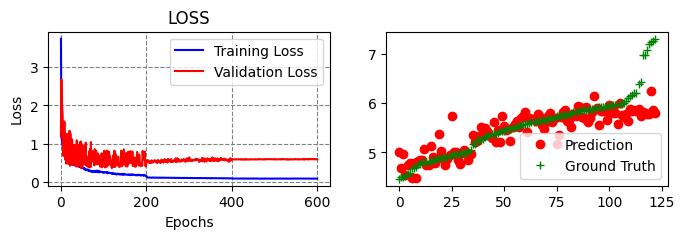

Pearson CC: 0.8216415816224355
R2 score: 0.6285017801882924
RMSE: 0.37444851489279635
MAE: 0.577677965098476
********************
Run # 1 Fold # 2
Training time: 0:00:45.812699


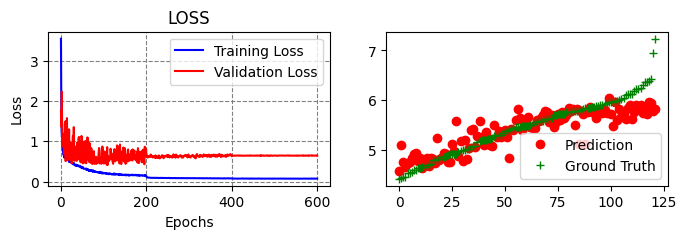

Pearson CC: 0.8636229532242925
R2 score: 0.7106719303664568
RMSE: 0.30206116106655756
MAE: 0.5549462829139841
********************
Run # 1 Fold # 3


Training time: 0:00:46.628717


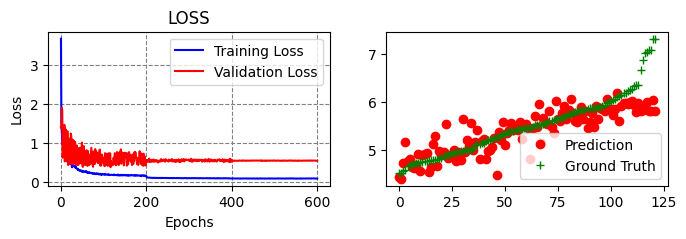

Pearson CC: 0.8119378448208424
R2 score: 0.6224875937669356
RMSE: 0.3861839317025789
MAE: 0.6182751523289397
********************
Run # 1 Fold # 4
Training time: 0:00:45.441529


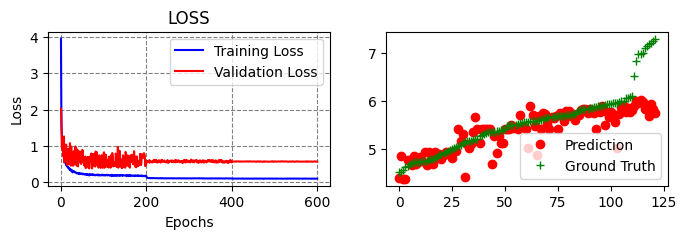

Pearson CC: 0.8070233600875549
R2 score: 0.5585162671087878
RMSE: 0.41524331742403975
MAE: 0.5932786990040625
********************
Run # 1 Fold # 5
Training time: 0:00:45.804401


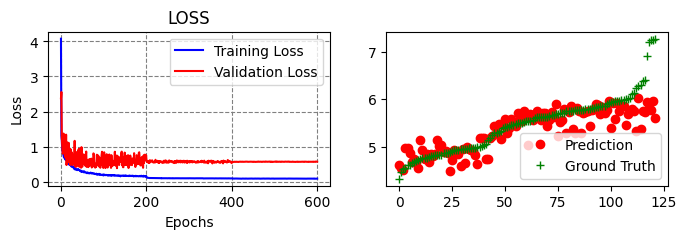

Pearson CC: 0.8135009712023396
R2 score: 0.6092745475911876
RMSE: 0.3742258888630611
MAE: 0.5824147234316005
********************


In [7]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=50+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            x_train, x_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = StandardScaler()
            x_train = scale.fit_transform(x_train)
            x_test = scale.transform(x_test)

            # define DNN
            model = Sequential()
            model.add(Input(shape=(17,)))
            model.add(Dense(1000,activation='relu'))
            model.add(Dense(200,activation='relu'))
            model.add(Dense(40,activation='relu'))
            model.add(Dense(1,activation='linear'))
            model.compile(optimizer= 'RMSprop', loss=root_mean_squared_error)

            # learning rate scheduler
            import math
            INITIAL_LEARNING_RATE = 0.01
            EPOCHS_NUM = 600
            def lr_step_decay(epoch, lr):
                drop_rate = 0.1
                epochs_drop = 200
                return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

            callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)]

            # Fit model
            t = now()
            history = model.fit(x_train, y_train, batch_size=16, epochs=EPOCHS_NUM,
                                validation_split=0.2, verbose=0, callbacks=callbacks)
            print('Training time: %s' % (now() - t))

            # Plot the loss and the predictions
            train_loss = history.history['loss']
            val_loss = history.history['val_loss']
            epochsn = np.arange(1, len(train_loss)+1,1)
            plt.figure(figsize=(8, 2))
            plt.subplot(1,2,1)
            plt.plot(epochsn,train_loss, 'b', label='Training Loss')
            plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
            plt.grid(color='gray', linestyle='--')
            plt.legend()
            plt.title('LOSS')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.subplot(1,2,2)
            y_pred_test = model.predict(x_test, verbose=0)
            plt.plot(y_pred_test, 'ro', label='Prediction')
            plt.plot(np.array(y_test), 'g+', label='Ground Truth')
            plt.legend(loc=4)
            plt.show()

            # Evaluate metrics
            PearsonCC[j, i] = pearsonr(y_test, np.squeeze(y_pred_test))[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = np.sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-np.array(y_test)))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            print(20*'*')

In [8]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE
0,0.821642,0.628502,0.374449,0.577678
1,0.863623,0.710672,0.302061,0.554946
2,0.811938,0.622488,0.386184,0.618275
3,0.807023,0.558516,0.415243,0.593279
4,0.813501,0.609275,0.374226,0.582415


In [9]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std
0,0.823545,0.020584,0.62589,0.049034,0.370433,0.037313,0.585319,0.020682


In [10]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)
upper_coverage_mean = np.mean(upper_coverage)
lower_coverage_mean = np.mean(lower_coverage)
mean_interval_width_mean = np.mean(mean_interval_width)
median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)
upper_coverage_std = np.std(upper_coverage)
lower_coverage_std = np.std(lower_coverage)
mean_interval_width_std = np.std(mean_interval_width)
median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std, 'Upper Coverage Mean': upper_coverage_mean, 'Upper Coverage Std': upper_coverage_std,
                  'Lower Coverage Mean': lower_coverage_mean, 'Lower Coverage Std': lower_coverage_std,
                    'Mean Interval Width Mean': mean_interval_width_mean, 'Mean Interval Width Std':mean_interval_width_std,
                    'Median Interval Width Mean': median_interval_width_mean, 'Median Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

NameError: name 'test_coverage' is not defined